In [1]:
import torch
from time import time
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from zipfile import ZipFile
import numpy as np
from time import time
from torchvision import datasets
from torchvision import transforms
import pandas as pd
import numpy as np
import zipfile
import re
import os
from PIL import Image
from torchvision.io import read_image
from matplotlib import image
from prepare_dataset import MyDataset,subset_generator
from utils import display_some_images,stats_of_image_and_label,MyCuda_Stats,get_output_features_of_model,display_image
from vgg_pretrained import vgg_all_freezed,total_trainable_parameters,full_vgg,vgg_layer_freeze
from Model import Network,new_model
from Transform import Transform
from train_fn import train,validation,image_validation,validation_classes,train_w_transform
from tqdm import tqdm
from sklearn.metrics import classification_report


D:\anaconda\envs\affectnet2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fullvgg=full_vgg()
total_trainable_parameters(fullvgg)
total_trainable_parameters(fullvgg.features)
total_trainable_parameters(vgg_all_freezed())
total_trainable_parameters(vgg_layer_freeze(24))


Total trainable parameters of VGG is 	 138357544

Total trainable parameters of Sequential is 	 14714688

Total trainable parameters of Sequential is 	 0

Total trainable parameters of Sequential is 	 7079424


In [33]:
# DATA LOADER PARAMETERS
batch=64
CUDA_LAUNCH_BLOCKING=1 

In [34]:
MyCuda_Stats()

No of GPUs i have is 1
0
My Graphic Card is NVIDIA GeForce RTX 2070 SUPER
Is Cuda Available True


In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(),normalize])
target_transform=transforms.Compose([transforms.ToTensor()])

In [6]:
anno_dir=r"./01_data/train_set/annotations"
image_dir=r"./01_data/train_set/images"
train_data=MyDataset(anno_dir,image_dir,transform=transform, target_transform=None)

In [7]:
val_anno_dir=r"./01_data/val_set/annotations"
val_image_dir=r"./01_data/val_set/images"
val_data=MyDataset(val_anno_dir,val_image_dir,transform=transform, target_transform=None)

In [8]:
Subset_train_sampler=subset_generator(train_data,5000)

In [35]:
train_loader=torch.utils.data.DataLoader(train_data,
                                         batch_size=batch,
                                         shuffle=False,
                                         num_workers=4,
                                         pin_memory=True,
                                         sampler=None)
val_loader=torch.utils.data.DataLoader(val_data,
                                       batch_size=batch,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)
val_loader_class=torch.utils.data.DataLoader(val_data,
                                       batch_size=1,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)

In [36]:
print(len(train_loader))
print(len(val_loader))


4495
63


In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [12]:
feature_extractor=vgg_layer_freeze(17)
total_trainable_parameters(feature_extractor)



Total trainable parameters of Sequential is 	 12979200


In [13]:

#input_features_for_denselayer=get_output_features_of_model(model=feature_extractor,batch_size=32,dataloader=train_loader)
input_features_for_denselayer=25088


In [14]:
t_image=Transform(input_features_for_denselayer)
model1=new_model(feature_extractor,input_features_for_denselayer).to(device)
model1

new_model(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [15]:
total_trainable_parameters(model1)


Total trainable parameters of new_model is 	 115776520


In [16]:
lr=0.0001
loss1=nn.CrossEntropyLoss()
optimizer=optim.Adam(model1.parameters(),lr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


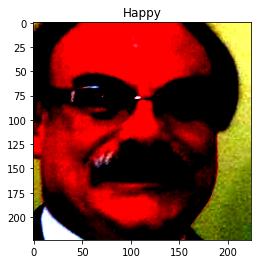

In [17]:
display_image(train_data[0][0],train_data[0][1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


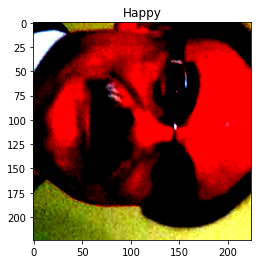

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


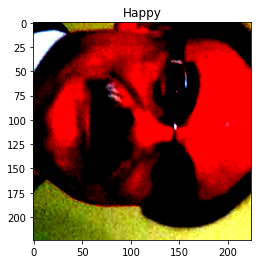

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


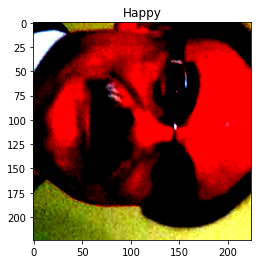

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


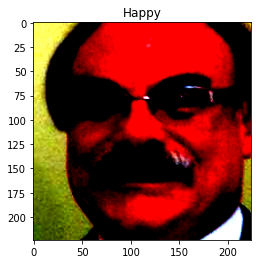

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


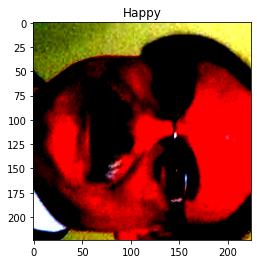

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


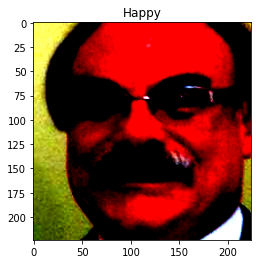

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


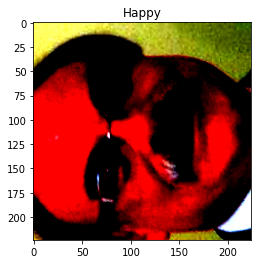

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


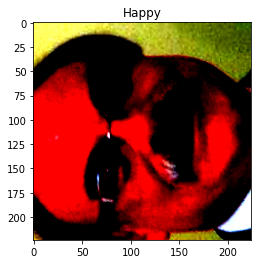

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


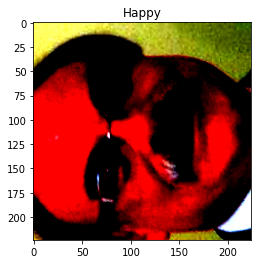

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


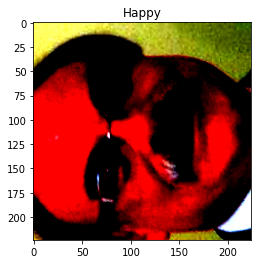

In [18]:
for _ in range(10):
    display_image(t_image.tran(train_data[0][0]),train_data[0][1])

In [19]:
model1.load_state_dict(torch.load(r"./01_data/modelrecent.pth"))

<All keys matched successfully>

In [20]:
#optimizer.load_state_dict(torch.load(r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\optimizer1.pth"))

In [40]:
validation(val_loader,model1,loss1)


100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

test error-2.456801 
 Accuracy-47.186797%


In [38]:
val_loader_class=torch.utils.data.DataLoader(val_data,
                                       batch_size=1,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)

In [23]:
classes=['Neutral','Happy','Sad','Surprise','Fear','Disgust','Anger','Contempt']


In [31]:
c_dict={}
for c in classes:
    c_dict[c]=0
for _,(image,label) in enumerate(tqdm(train_data)):
    #print(label)
    c_dict[classes[int(label)]]+=1
print(c_dict)

100%|██████████| 287651/287651 [07:31<00:00, 637.67it/s]

{'Neutral': 74874, 'Happy': 134415, 'Sad': 25459, 'Surprise': 14090, 'Fear': 6378, 'Disgust': 3803, 'Anger': 24882, 'Contempt': 3750}


In [41]:
validation_classes(val_loader_class,model1,loss1,0)

100%|██████████| 3999/3999 [00:14<00:00, 280.88it/s]

test error-0.759452 
 Accuracy-72.600000%


In [42]:
validation_classes(val_loader_class,model1,loss1,1)

100%|██████████| 3999/3999 [00:12<00:00, 311.16it/s]

test error-0.267937 
 Accuracy-90.000000%


In [43]:
validation_classes(val_loader_class,model1,loss1,2)

100%|██████████| 3999/3999 [00:13<00:00, 305.83it/s]

test error-1.821165 
 Accuracy-51.000000%


In [44]:
validation_classes(val_loader_class,model1,loss1,3)

100%|██████████| 3999/3999 [00:12<00:00, 312.60it/s]

test error-2.804659 
 Accuracy-36.400000%


In [45]:
validation_classes(val_loader_class,model1,loss1,4)

100%|██████████| 3999/3999 [00:12<00:00, 308.51it/s]

test error-2.959716 
 Accuracy-40.000000%


In [46]:
validation_classes(val_loader_class,model1,loss1,5)

100%|██████████| 3999/3999 [00:13<00:00, 305.94it/s]

test error-4.566542 
 Accuracy-24.800000%


In [47]:
validation_classes(val_loader_class,model1,loss1,6)

100%|██████████| 3999/3999 [00:12<00:00, 309.98it/s]

test error-2.047753 
 Accuracy-52.000000%


In [48]:
validation_classes(val_loader_class,model1,loss1,7)

100%|██████████| 3999/3999 [00:12<00:00, 310.64it/s]

test error-4.366577 
 Accuracy-10.621242%


In [39]:
# NO OF EPOCHS IS 5
epochs=50
for epoch in range(epochs):
    print(f'Epoch-{epoch}')
    train_w_transform(train_loader,model1,loss1,optimizer,t_image)
    validation(val_loader,model1,loss1)


Epoch-0


100%|██████████| 4495/4495 [20:35<00:00,  3.64it/s]


loss:0.759244 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.85it/s]


test error-1.662118 
 Accuracy-47.311828%
Epoch-1


100%|██████████| 4495/4495 [20:34<00:00,  3.64it/s]


loss:0.731711 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.84it/s]


test error-1.677765 
 Accuracy-48.112028%
Epoch-2


100%|██████████| 4495/4495 [20:33<00:00,  3.64it/s]


loss:0.620836 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-1.634208 
 Accuracy-48.562141%
Epoch-3


100%|██████████| 4495/4495 [20:34<00:00,  3.64it/s]


loss:0.700439 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.78it/s]


test error-1.575755 
 Accuracy-49.562391%
Epoch-4


100%|██████████| 4495/4495 [20:33<00:00,  3.64it/s]


loss:0.634890 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-1.672090 
 Accuracy-47.086772%
Epoch-5


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.601565 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-1.603177 
 Accuracy-49.937484%
Epoch-6


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.502018 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


test error-1.682207 
 Accuracy-48.387097%
Epoch-7


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.725501 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.77it/s]


test error-1.657242 
 Accuracy-49.937484%
Epoch-8


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.368602 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.87it/s]


test error-1.677214 
 Accuracy-48.637159%
Epoch-9


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.622417 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


test error-1.748231 
 Accuracy-48.537134%
Epoch-10


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.666791 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-1.621732 
 Accuracy-48.762191%
Epoch-11


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.603227 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


test error-1.835652 
 Accuracy-48.887222%
Epoch-12


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.491069 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-1.651450 
 Accuracy-49.412353%
Epoch-13


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.455527 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-1.752885 
 Accuracy-49.212303%
Epoch-14


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.359710 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-1.727521 
 Accuracy-49.437359%
Epoch-15


100%|██████████| 4495/4495 [20:33<00:00,  3.64it/s]


loss:0.663287 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


test error-1.812846 
 Accuracy-48.437109%
Epoch-16


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.781489 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.87it/s]


test error-1.862117 
 Accuracy-47.861965%
Epoch-17


100%|██████████| 4495/4495 [20:33<00:00,  3.65it/s]


loss:0.405813 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.86it/s]


test error-1.970219 
 Accuracy-49.387347%
Epoch-18


100%|██████████| 4495/4495 [20:33<00:00,  3.64it/s]


loss:0.607597 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.85it/s]


test error-1.915438 
 Accuracy-48.262066%
Epoch-19


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.261752 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.81it/s]


test error-1.857549 
 Accuracy-48.787197%
Epoch-20


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.467987 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


test error-1.780759 
 Accuracy-48.037009%
Epoch-21


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.433756 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


test error-1.858155 
 Accuracy-47.611903%
Epoch-22


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.399104 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.87it/s]


test error-2.092496 
 Accuracy-49.237309%
Epoch-23


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.581504 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-1.805023 
 Accuracy-48.837209%
Epoch-24


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.275742 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


test error-1.816337 
 Accuracy-48.037009%
Epoch-25


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.619462 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.85it/s]


test error-1.933506 
 Accuracy-49.037259%
Epoch-26


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.403818 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.90it/s]


test error-2.051256 
 Accuracy-49.887472%
Epoch-27


100%|██████████| 4495/4495 [20:33<00:00,  3.64it/s]


loss:0.263156 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


test error-2.060940 
 Accuracy-48.612153%
Epoch-28


100%|██████████| 4495/4495 [20:34<00:00,  3.64it/s]


loss:0.702479 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.87it/s]


test error-2.072987 
 Accuracy-48.137034%
Epoch-29


100%|██████████| 4495/4495 [20:35<00:00,  3.64it/s]


loss:0.328540 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


test error-2.026555 
 Accuracy-48.312078%
Epoch-30


100%|██████████| 4495/4495 [20:34<00:00,  3.64it/s]


loss:0.165080 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.90it/s]


test error-2.020159 
 Accuracy-48.562141%
Epoch-31


100%|██████████| 4495/4495 [20:35<00:00,  3.64it/s]


loss:0.453500 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.84it/s]


test error-2.075153 
 Accuracy-48.112028%
Epoch-32


100%|██████████| 4495/4495 [20:34<00:00,  3.64it/s]


loss:0.206587 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.90it/s]


test error-2.259351 
 Accuracy-48.412103%
Epoch-33


100%|██████████| 4495/4495 [20:35<00:00,  3.64it/s]


loss:0.120677 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-2.191845 
 Accuracy-48.487122%
Epoch-34


100%|██████████| 4495/4495 [20:34<00:00,  3.64it/s]


loss:0.103816 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.83it/s]


test error-2.237688 
 Accuracy-47.486872%
Epoch-35


100%|██████████| 4495/4495 [20:34<00:00,  3.64it/s]


loss:0.343742 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.79it/s]


test error-2.543718 
 Accuracy-48.037009%
Epoch-36


100%|██████████| 4495/4495 [20:34<00:00,  3.64it/s]


loss:0.076131 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.85it/s]


test error-2.180207 
 Accuracy-48.512128%
Epoch-37


100%|██████████| 4495/4495 [20:34<00:00,  3.64it/s]


loss:0.128181 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


test error-2.266853 
 Accuracy-47.536884%
Epoch-38


100%|██████████| 4495/4495 [20:33<00:00,  3.64it/s]


loss:0.504776 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-2.264591 
 Accuracy-46.836709%
Epoch-39


100%|██████████| 4495/4495 [20:33<00:00,  3.64it/s]


loss:0.099090 batch:4494/4495


100%|██████████| 63/63 [00:29<00:00,  2.13it/s]


test error-2.564938 
 Accuracy-48.162041%
Epoch-40


100%|██████████| 4495/4495 [20:33<00:00,  3.64it/s]


loss:0.583569 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.85it/s]


test error-2.483817 
 Accuracy-48.062016%
Epoch-41


100%|██████████| 4495/4495 [20:34<00:00,  3.64it/s]


loss:0.354402 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-2.372133 
 Accuracy-48.212053%
Epoch-42


100%|██████████| 4495/4495 [20:34<00:00,  3.64it/s]


loss:0.160171 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-2.643079 
 Accuracy-47.186797%
Epoch-43


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.397589 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


test error-2.437420 
 Accuracy-47.836959%
Epoch-44


100%|██████████| 4495/4495 [20:31<00:00,  3.65it/s]


loss:0.204543 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.87it/s]


test error-2.481262 
 Accuracy-48.612153%
Epoch-45


100%|██████████| 4495/4495 [20:33<00:00,  3.64it/s]


loss:0.507506 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-2.001614 
 Accuracy-48.337084%
Epoch-46


100%|██████████| 4495/4495 [20:32<00:00,  3.65it/s]


loss:0.097913 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.81it/s]


test error-2.494582 
 Accuracy-48.212053%
Epoch-47


100%|██████████| 4495/4495 [20:31<00:00,  3.65it/s]


loss:0.038165 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


test error-2.513385 
 Accuracy-47.711928%
Epoch-48


100%|██████████| 4495/4495 [20:33<00:00,  3.65it/s]


loss:0.440267 batch:4494/4495


100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


test error-2.059088 
 Accuracy-49.562391%
Epoch-49


100%|██████████| 4495/4495 [20:35<00:00,  3.64it/s]


loss:0.164915 batch:4494/4495


100%|██████████| 63/63 [00:22<00:00,  2.80it/s]

test error-2.456801 
 Accuracy-47.186797%


In [ ]:
torch.save(model1.state_dict(), r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\modelrecent.pth")

In [ ]:
torch.save(optimizer.state_dict(), r"C:\Users\DELL\Desktop\Python\Affect_Net\Affectnet\models\optimizerrecent.pth")

In [53]:
torch.cuda.empty_cache()

In [54]:
torch.cuda.memory_summary(device='cuda', abbreviated=True)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    1774 MB |    3057 MB |    1438 TB |    1438 TB |\n|---------------------------------------------------------------------------|\n| Active memory         |    1774 MB |    3057 MB |    1438 TB |    1438 TB |\n|---------------------------------------------------------------------------|\n| GPU reserved memory   |    2182 MB |    3852 MB |    3852 MB |    1670 MB |\n|--------------------------------------------------